<a href="https://colab.research.google.com/github/BanuB/Banking_Deposit_Classification/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Goals:

1.   Create a Decision Tree where you can solve a classification problem and predict the outcome of a particular feature or detail of the data used.
2.   Switch variables* to generate 2 decision trees and compare the results. Create a random forest and analyze the results.

1.   Based on real cases where desicion trees went wrong, and 'the bad & ugly' aspects of decision trees (https://decizone.com/blog/the-good-the-bad-the-ugly-of-using-decision-trees), how can you change this perception when using the decision tree you created to solve a real problem?















## Predicting Precision-Marketing Effectiveness in Banking

This project aims to predict the effectiveness of precision-marketing for clients to purchase a long-term investment product (e.g., certificate of deposit, CD) at a financial institution. The data is derived from Migueis et al. (2017, doi: 10.1007/s11628-016-0332-3). The dataset consists of about 30,000 labeled customers and variables such as profession, marital status, education, loan status, and more seen below. The labels are whether the customers were receptive to a specific marketing campagne, and the goals are to predict future client receptiveness, as well as creating a client profile that will be receptive to such CD product.

Below, the data is loaded out of a github repo, and then subjected to a quick EDA showcasing the feature distributions as well as correlation matrices. Following that, decision tree models are used to create the predictive model. Firstly, a single decision tree is used, followed by another single tree with respective variables excluded (e.g., duration, pdays). The duration features stands for the amount the phone call took, and the pdays stands for the amount of days since the last call. Lastly, a random forest model is used to compare a bagged solution to a single tree. Additionally, SHAP values are utilized in order to explain the random forest model and also build said customer profile.

### Loading Libraries and Data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
import numpy as np
import shap
import random

C:\Users\f9tbqno\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load data
cc = pd.read_csv('https://raw.githubusercontent.com/lucasweyrich958/Banking_Deposit_Classification/refs/heads/main/Marketing_Dataset.csv')

#Glimpse into dataset
cc.info()
cc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


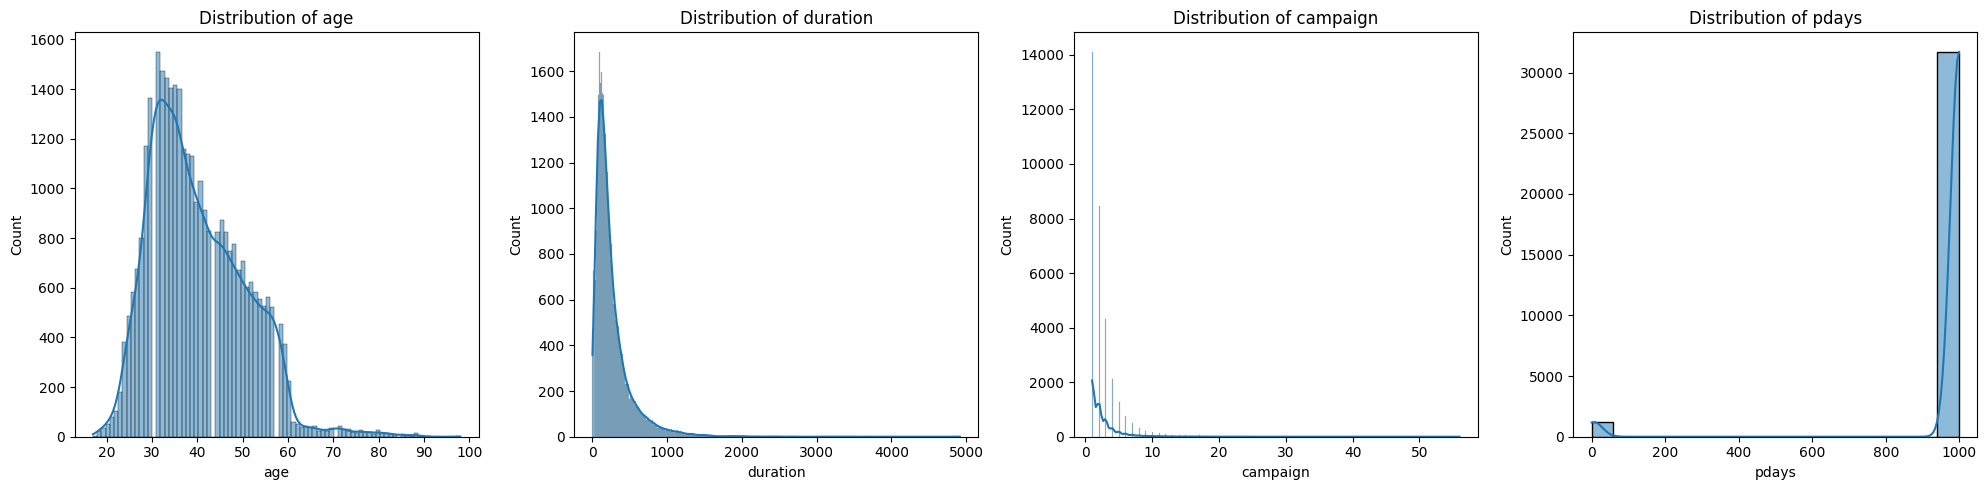

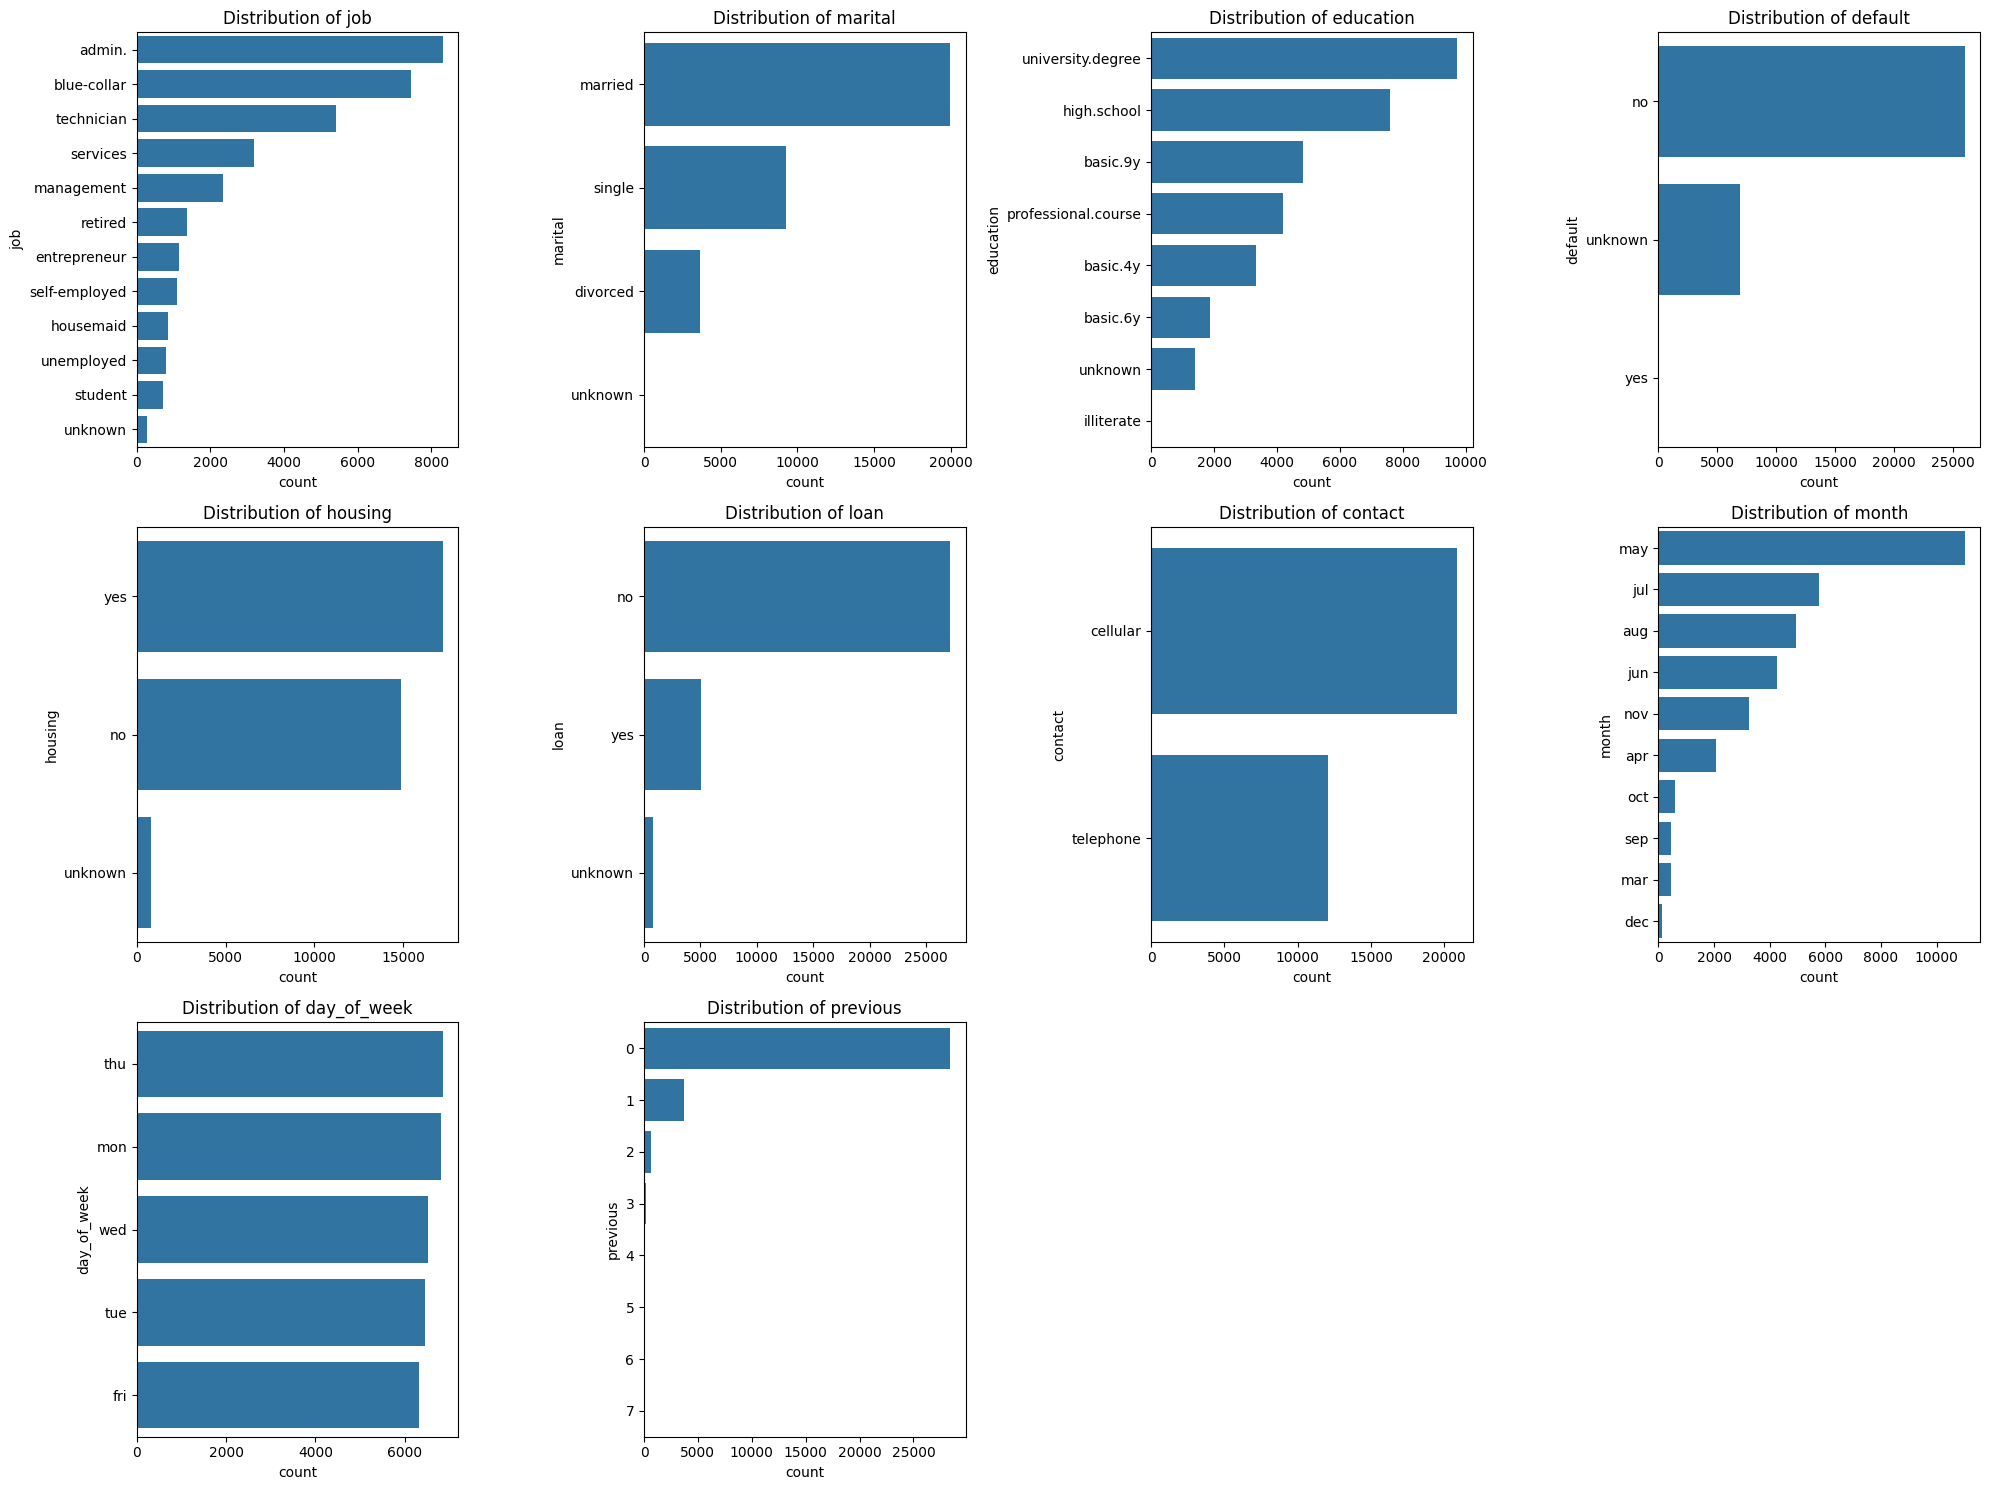

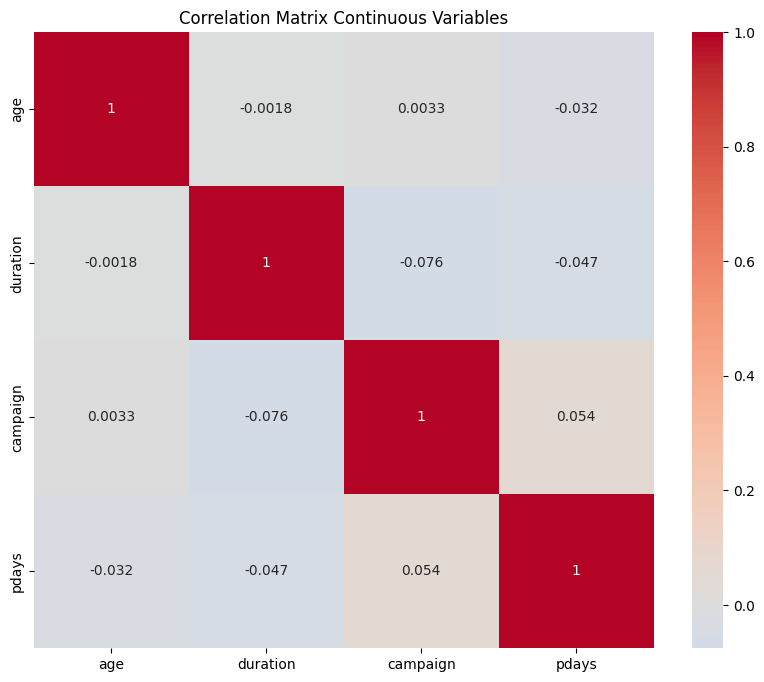

In [4]:
#Select continuous variables
continuous_vars = ['age', 'duration', 'campaign', 'pdays']
n_continuous = len(continuous_vars)
rows_continuous = (n_continuous + 3) // 4  #determine the number of rows needed

#Plot distributions of continuous variables
fig, axes = plt.subplots(rows_continuous, 4, figsize=(20, 5 * rows_continuous))
axes = axes.flatten()
for i, var in enumerate(continuous_vars):
    sns.histplot(cc[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_continuous, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Plot distributions for categorical variables
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous']
n_categorical = len(categorical_vars)
rows_categorical = (n_categorical + 3) // 4  #determine the number of rows needed

fig, axes = plt.subplots(rows_categorical, 4, figsize=(20, 5 * rows_categorical))
axes = axes.flatten()
for i, var in enumerate(categorical_vars):
    sns.countplot(y=cc[var], ax=axes[i], order=cc[var].value_counts().index)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_categorical, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Correlation for continuous variables
corr_cont = cc[continuous_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cont, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Continuous Variables')
plt.show()



Disadvantages of the Decision Tree based on the blog.

**Repeat:** We can see that the decision rules show repeating patterns in multiple branches of the tree.

**Complexity:** Any decision tree created with detailed thought process might look complicated when you see it in a diagram.

**Familiarity:** At times people use obscure elements/features inside their decision trees.

* Note:
1. We are trying to train 2 different decision trees to compare bias and variance - so swicth the features used for the first node (split) to force a different decision tree (How did the performance change?)
2. You will create 3 models: 2 x decision trees (to compare variance) and a random forest

### Single Decision Tree

In [5]:
random.seed(958) #Set seed

#Encode categorical variables
label_encoders = {}
for column in cc.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    cc[column] = label_encoders[column].fit_transform(cc[column])

#Split dataset into features and target variable
X = cc.drop('y', axis=1)
y = cc['y']

#Split data into train and test sets using 70/30 allocation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Hyperparameter Tuning using Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
} #Using more standard values

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

#Select best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

#Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Best Model - Accuracy: 0.91
Best Model - Precision: 0.64
Best Model - AUC: 0.89


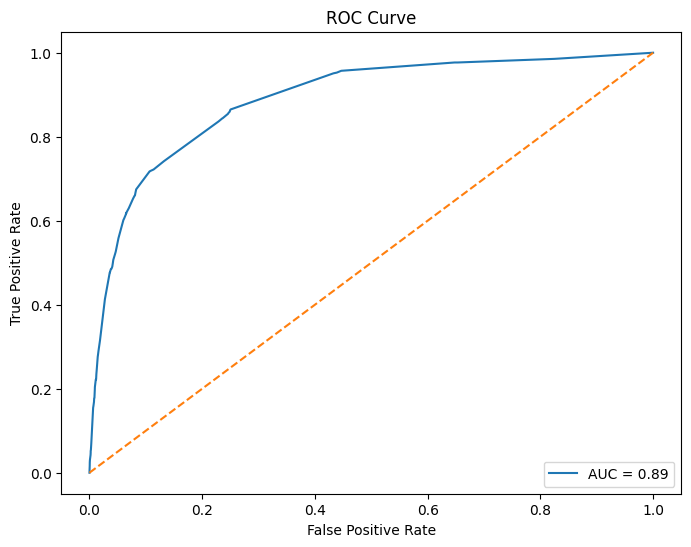

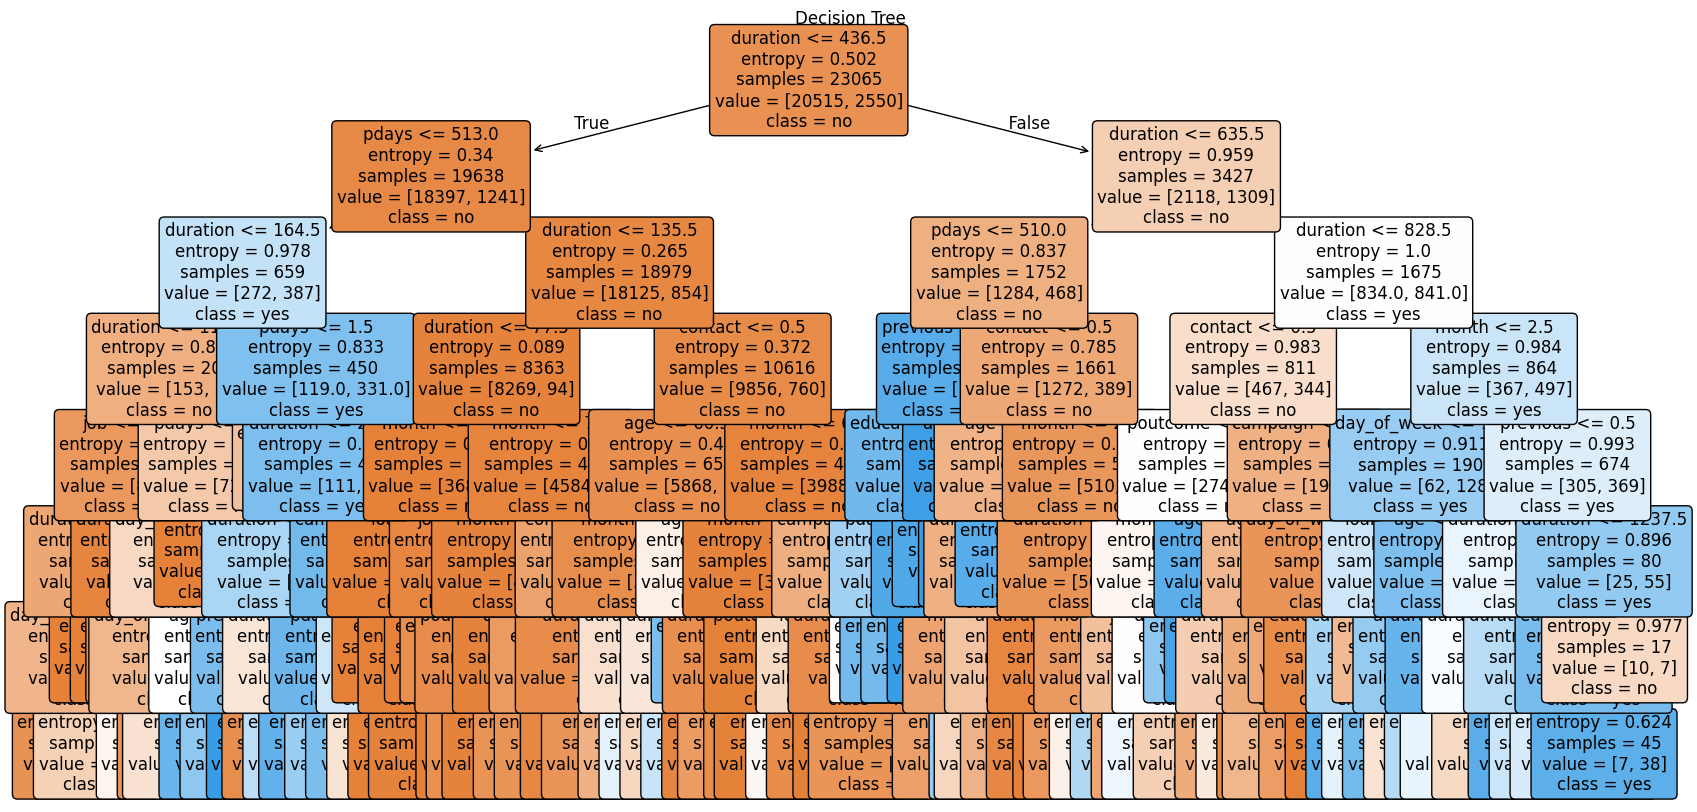

In [6]:
#Testing the set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

#Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

best_model_results = {"Accuracy": accuracy, "Precision": precision, "AUC": auc}

print(f"Best Model - Accuracy: {accuracy:.2f}")
print(f"Best Model - Precision: {precision:.2f}")
print(f"Best Model - AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Decision Tree')
plt.show()

In [9]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

feature_cols = X.columns.tolist()

dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('best_model.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [10]:
# Function to extract rules
def get_rules(tree, feature_names):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(f"{indent}if ( {features[node]} <= {threshold[node]} ):")
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth+1)
            print(f"{indent}else: # if {features[node]} > {threshold[node]}")
            if right[node] != -1:
                recurse(left, right, threshold, features, right[node], depth+1)
        else:
            print(f"{indent}return {np.argmax(value[node])}")
    recurse(left, right, threshold, features, 0)



In [11]:
# Extract and print rules
get_rules(best_model, feature_cols)

# This example provides a more detailed approach to extract decision rules from a DecisionTreeClassifier. It traverses the tree structure recursively and prints out the decision rules in a human-readable format.

if ( duration <= 436.5 ):
  if ( pdays <= 513.0 ):
    if ( duration <= 164.5 ):
      if ( duration <= 117.0 ):
        if ( job <= 6.5 ):
          if ( duration <= 108.5 ):
            if ( day_of_week <= 1.5 ):
              return 0
            else: # if day_of_week > 1.5
              return 0
          else: # if duration > 108.5
            return 0
        else: # if job > 6.5
          if ( duration <= 95.5 ):
            return 0
          else: # if duration > 95.5
            return 0
      else: # if duration > 117.0
        if ( pdays <= 9.5 ):
          if ( day_of_week <= 1.5 ):
            if ( day_of_week <= 0.5 ):
              return 0
            else: # if day_of_week > 0.5
              return 0
          else: # if day_of_week > 1.5
            if ( age <= 55.0 ):
              return 0
            else: # if age > 55.0
              return 1
        else: # if pdays > 9.5
          return 0
    else: # if duration > 164.5
      if ( pdays <= 1.5 ):
        re

### Single Decision Tree (Reduced)

In [12]:
random.seed(958)
#Dropping duration and pdays features
X_reduced = X.drop(['duration', 'pdays'], axis=1)

#Split the data again with the reduced dataset
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#Train the reduced model with the same hyperparameters
custom_model = DecisionTreeClassifier(**best_params, random_state=42)
custom_model.fit(X_train_reduced, y_train_reduced)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Reduced Model - Accuracy: 0.89
Reduced Model - Precision: 0.60
Reduced Model - AUC: 0.73


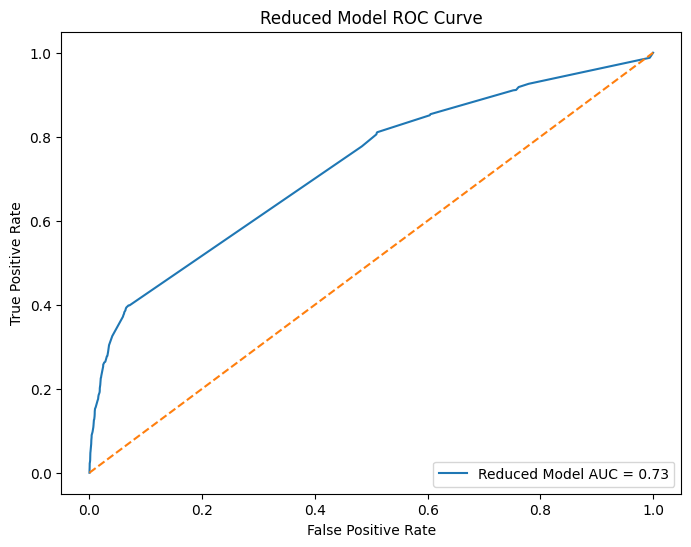

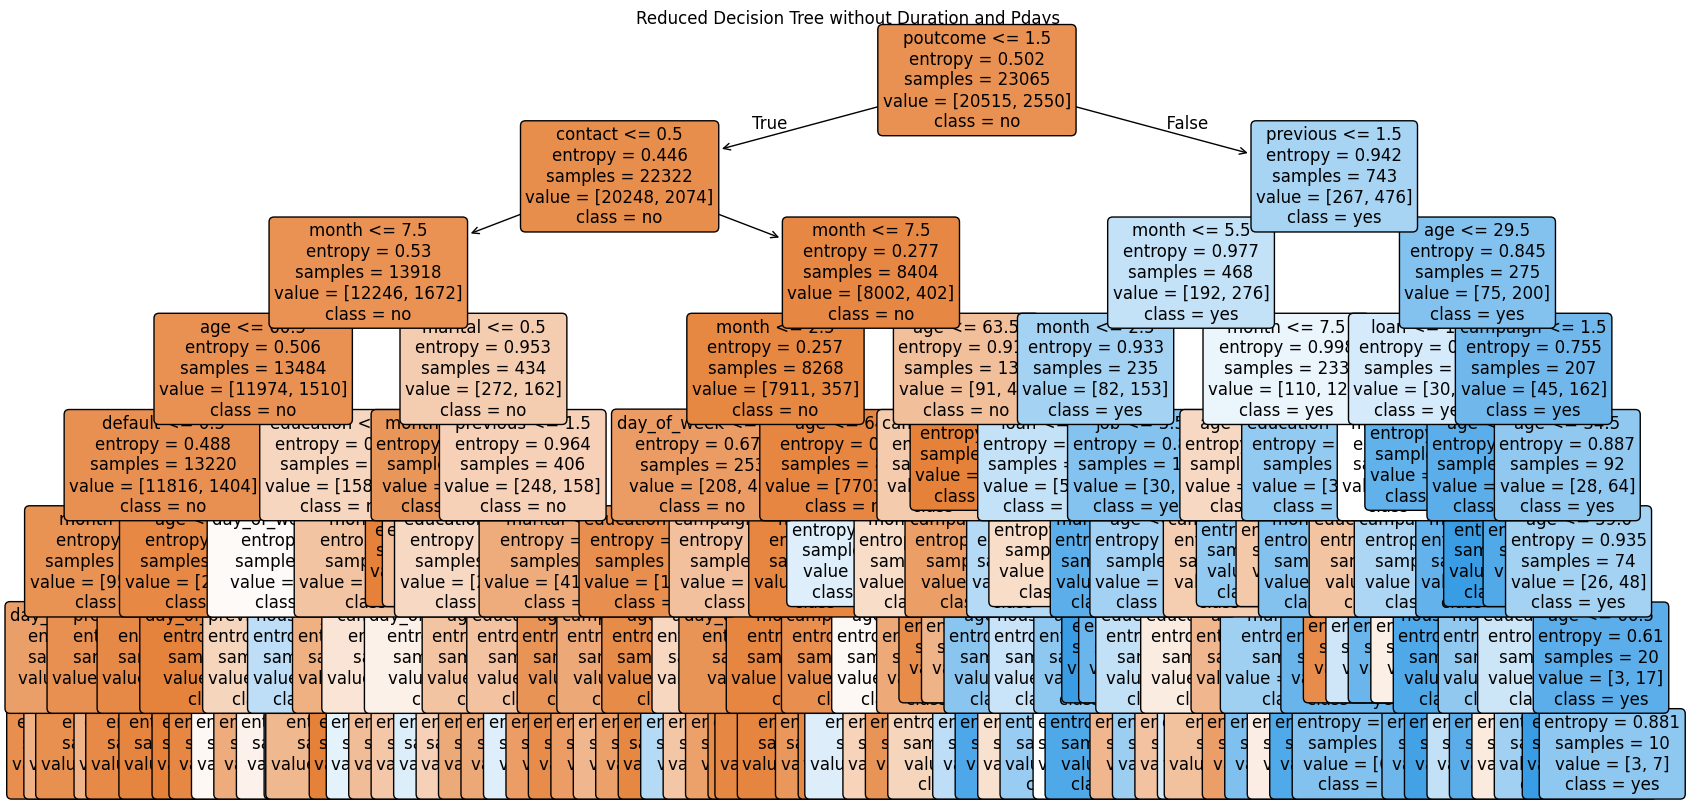

In [13]:
#Test reduced model
y_pred_custom = custom_model.predict(X_test_reduced)
y_proba_custom = custom_model.predict_proba(X_test_reduced)[:, 1]

#Calculate metrics for the custom model
accuracy_custom = accuracy_score(y_test_reduced, y_pred_custom)
precision_custom = precision_score(y_test_reduced, y_pred_custom)
auc_custom = roc_auc_score(y_test_reduced, y_proba_custom)

custom_model_results = {"Accuracy": accuracy_custom, "Precision": precision_custom, "AUC": auc_custom}

print(f"Reduced Model - Accuracy: {accuracy_custom:.2f}")
print(f"Reduced Model - Precision: {precision_custom:.2f}")
print(f"Reduced Model - AUC: {auc_custom:.2f}")

#Plot ROC Curve for the custom model
fpr_custom, tpr_custom, _ = roc_curve(y_test_reduced, y_proba_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr_custom, tpr_custom, label=f'Reduced Model AUC = {auc_custom:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reduced Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot custom model tree
plt.figure(figsize=(20, 10))
plot_tree(custom_model, filled=True, feature_names=X_reduced.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Reduced Decision Tree without Duration and Pdays')
plt.show()

In [13]:
feature_cols = X_train_reduced.columns.tolist()

dot_data = StringIO()
export_graphviz(custom_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('custom_model.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### Random Forest Model

Random Forest Model - Accuracy: 0.90
Random Forest Model - Precision: 0.65
Random Forest Model - AUC: 0.92


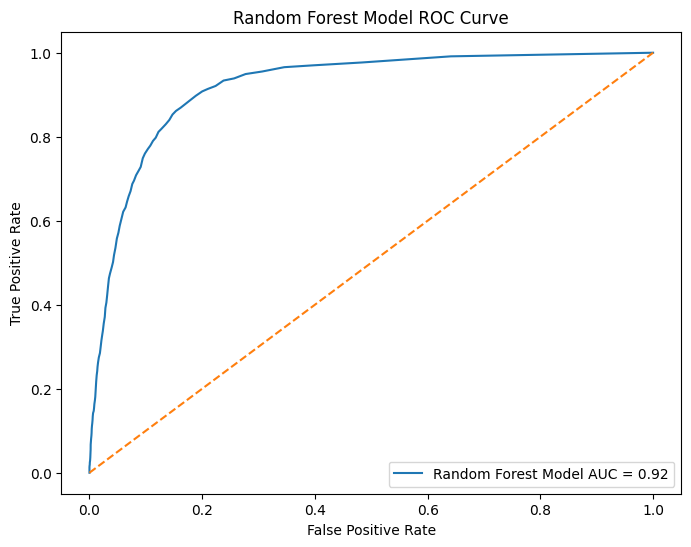

In [14]:
random.seed(958)
#Running Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

#Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#Calculate metrics for the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

rf_model_results = {"Accuracy": accuracy_rf, "Precision": precision_rf, "AUC": auc_rf}

print(f"Random Forest Model - Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Model - Precision: {precision_rf:.2f}")
print(f"Random Forest Model - AUC: {auc_rf:.2f}")

#Plot ROC Curve for the Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest Model AUC = {auc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model Comparison

In [15]:
#Compare the performance of the best model and the custom model
comparison_df = pd.DataFrame([best_model_results, custom_model_results, rf_model_results], index=['Best Model', 'Custom Model', 'Random Forest Model'])
print(comparison_df)

                     Accuracy  Precision       AUC
Best Model           0.906727   0.638249  0.888354
Custom Model         0.889833   0.604585  0.728071
Random Forest Model  0.903591   0.648649  0.919086


### Random Forest Explanations (SHAP Values)

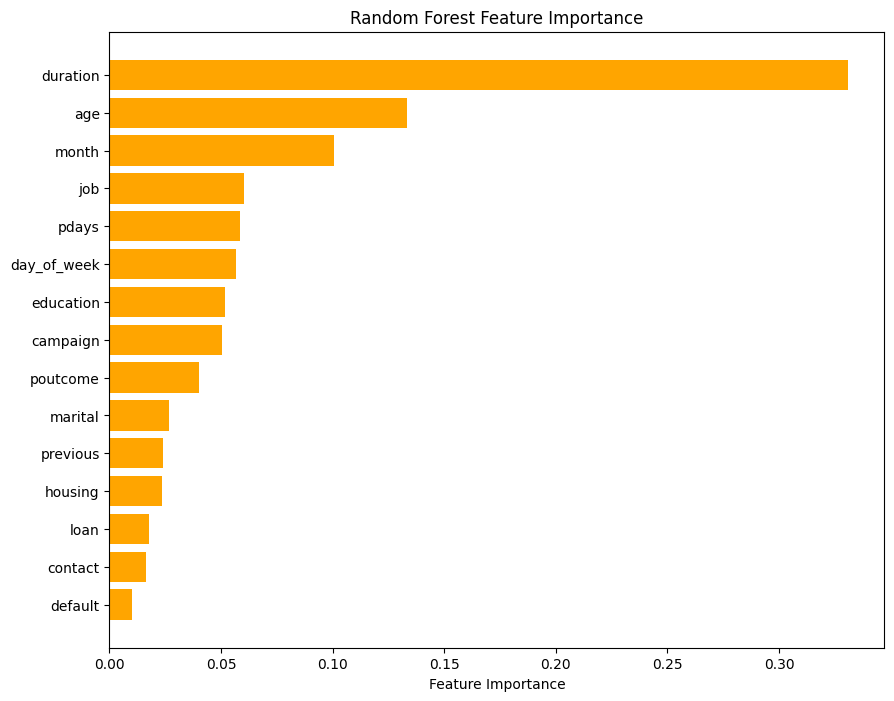

In [16]:
feature_names = X_train.columns.tolist()

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='orange')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### Essay Deliverable
The primary objective of this project was to predict whether a client would invest in a long-term certificate of deposit (CD) financial product, leveraging a precision-marketing strategy. By utilizing data collected from previous marketing campaigns, we aimed to forecast client receptiveness to this financial offering with greater accuracy and reliability.

The decision tree models presented above illustrate the underlying logic behind decision trees. These models split into two new branches at variables exhibiting low error, which enables them to achieve substantial accuracy. Interestingly, the single decision tree demonstrated higher accuracy than the bagged random forest model, albeit only in terms of standard accuracy metrics. However, the area under the curve (AUC) indicated that the random forest actually outperforms the decision tree in both accuracy and precision, showing its robustness in handling varied data patterns.

Nonetheless, our analysis also highlighted the decision tree's reliance on a few strong features. When the two most critical features were removed, the decision tree's performance significantly declined. Additionally, several disadvantages of decision trees were noted, as detailed in the accompanying blog post. For example, decision trees tend to repeat patterns across multiple branches. In the original single tree, the variable 'duration' was repeatedly split, potentially leading to overfitting and an overreliance on one feature. Such patterns lead to risks of the model becoming too specific to the training data, reducing its efficacy on new, unseen data.

In contrast, random forests aggregate the averages of many single trees, including those where 'duration' is not frequently split. This bagging technique mitigates the overfitting issue by ensuring that the model doesn't rely too heavily on any single predictor. However, examining the feature importance values revealed that 'duration' remains an inherently important feature even within the random forest model. Removing the two most critical features not only reduced performance but also resulted in smaller trees, which may not always be advantageous. In this case, all evaluation metrics, particularly the AUC, declined.

Moreover, the analysis underscored the interpretability of decision trees and their bagged extensions. A single decision tree can be easily traced, allowing for straightforward interpretation and explanation of its decisions. The bagged extension, meanwhile, can be intuitively explained using feature importance values derived from the ensemble model, or even better, SHAP values. For example, within the random forest model, the 'duration' of the call was the most influential factor in predicting whether clients would purchase a CD. This finding is logical, as clients who are more interested in the product tend to stay longer on the phone. 
Interestingly, the importance of 'age' and 'month' was also identified. It suggests that older adults might better appreciate the value of CDs compared to younger clients, who may have a greater need for liquid cash. Such insights are valuable as they provide actionable recommendations for targeted marketing strategies.

Additionally, the random forest model offers robustness and resilience in real-world scenarios. It is capable of providing consistent results across diverse sets of data, making it highly applicable for ongoing client engagement strategies. The capacity to handle high dimensionality and multi-collinearity without significant performance loss makes the random forest a highly versatile tool in the financial domain.
In conclusion, while both the single decision tree and the random forest model perform well in a production environment, the random forest demonstrates greater flexibility, requires less maintenance over time (e.g., retraining), and shows superior performance in predicting a client's investment decision in a CD based on precision-marketing strategies. Employing the random forest can lead to more accurate predictions and better client targeting, ultimately enhancing marketing efficiency and financial outcomes.
